# 1. Dataset Introduction & Loading

In [1]:
import pandas as pd

df = pd.read_csv('./data/short_seasonal.csv')

df['timestamp'] = pd.to_datetime(df['timestamp'])
ts = df.set_index("timestamp")["value"]
ts = ts.asfreq('ME')

lables = df.set_index("timestamp")["labels"]

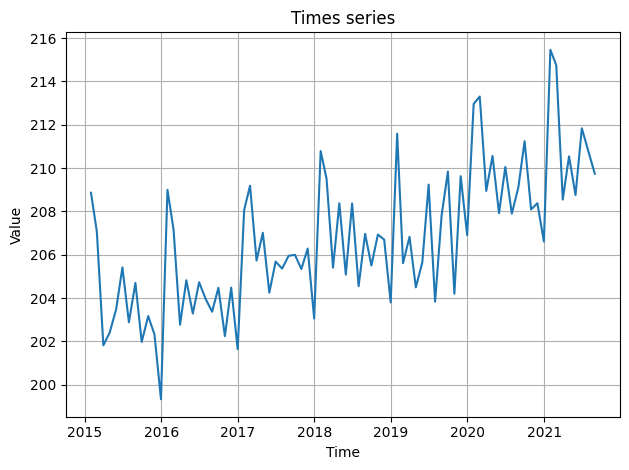

In [2]:
from src.visualization.plots import *

plot_ts(ts)

Graph observations:
- Yearly seasonality, values peek during the first 1-2 months every year
- Increasing trend, seems roughly linear

# 2. Modeling - Classical Statistics

## 2.1 STL Model

Lets start with a quick Seasonal-Trend decomposition to get an overall idea of the time series

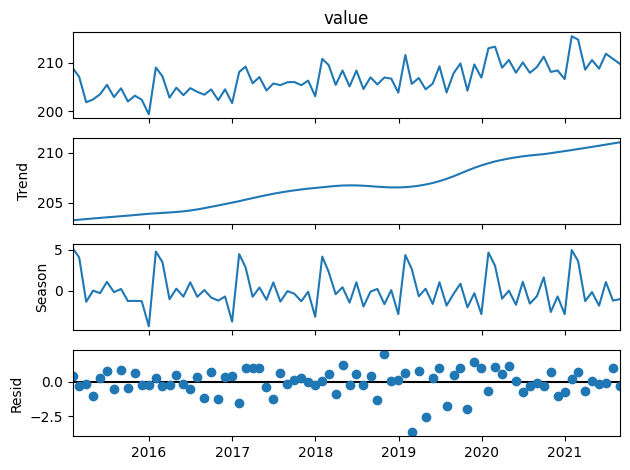

In [3]:
from statsmodels.tsa.seasonal import STL

stl = STL(ts, period=12) 
stl_result = stl.fit()

_ = stl_result.plot()

Graph observations:
- Mostly linear trend with a light wave shape from 2017-2020
- Larger residuals from late 2018 to late 2019

### Investigation: Linear Trend

In [4]:
from src.models.statistical.linear_models import linear_model

model, X = linear_model(stl_result.trend)
lin_results = model.fit()

print(lin_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     2357.
Date:                Tue, 29 Jul 2025   Prob (F-statistic):           4.80e-60
Time:                        14:30:29   Log-Likelihood:                -44.321
No. Observations:                  80   AIC:                             92.64
Df Residuals:                      78   BIC:                             97.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        202.7235      0.094   2145.908      0.0

The summary provides evidence that trend should be modeled linearly. With a $p$-value of $0.000$ for all parameters, there is strong evidence against any model parameters being zero, hence no need to drop parameters. The R-squared and Adj. R-squared are both high at $0.968$, showing $96.8\%$ of the response can be explained by the explanatory variables

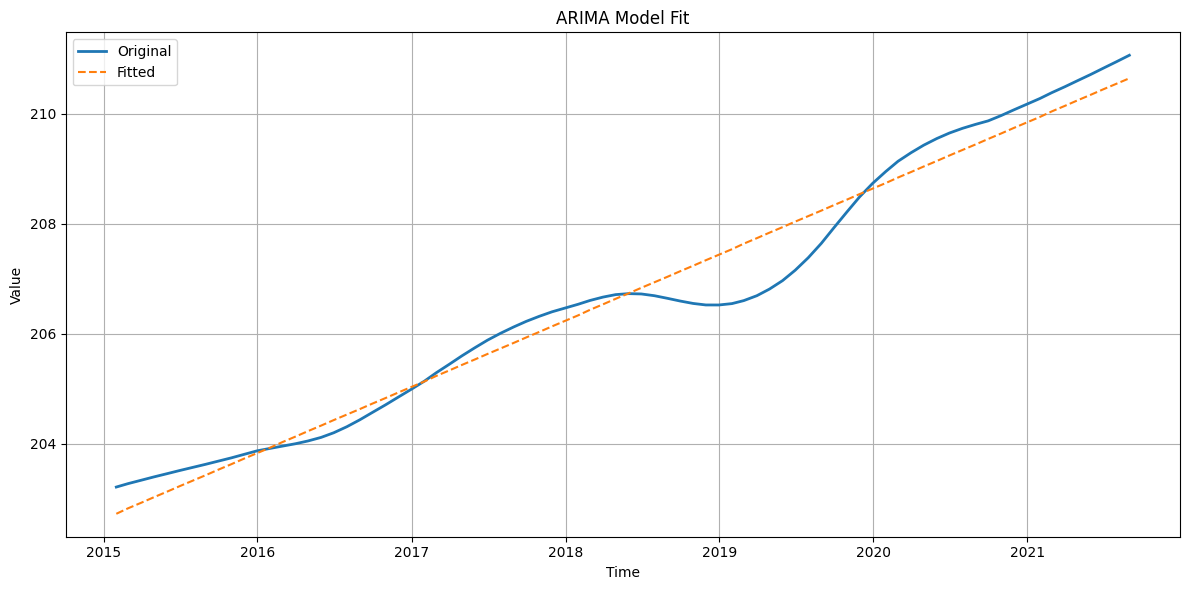

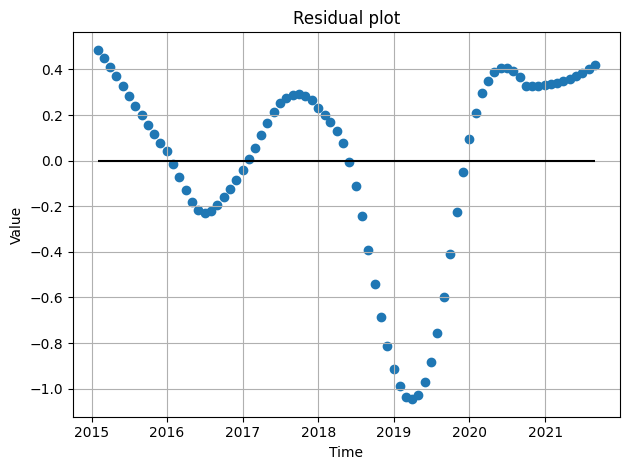

In [5]:
lin_pred = pd.Series(lin_results.predict(X), index=ts.index)
plot_fit(stl_result.trend, lin_pred)

lin_resid = pd.Series(lin_results.resid, index=ts.index)
plot_resid(lin_resid)

There is strong trend in the residual plot suggesting that the residuals are not indenpent and identiacally distributed normal. The original time series deviates futhest from the preditions from late 2018 to late 2019 $(|r_i|>0.5)$

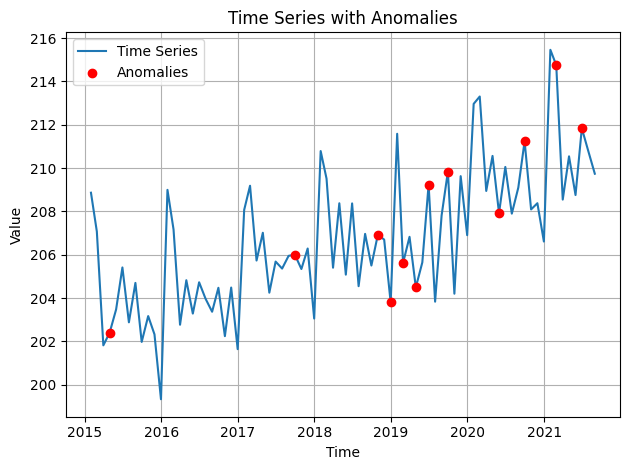

In [6]:
from src.models.statistical.rule_based_functions import *

cusum_trend = cusum(lin_resid, lin_resid.mean(), threshold=(3 * lin_resid.std()), drift=(0.1 * lin_resid.std()))
plot_ts_with_anom(ts, cusum_trend)

Unsurprisingly, running CUSUM on the trend residuals labels points where residuals are consistently far away from their mean value. Such residuals seems occur more frequently in late 2018 to late 2019.

### Investigation: Residuals

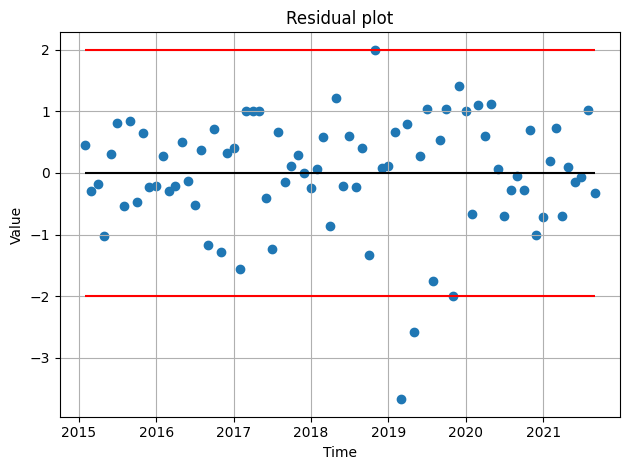

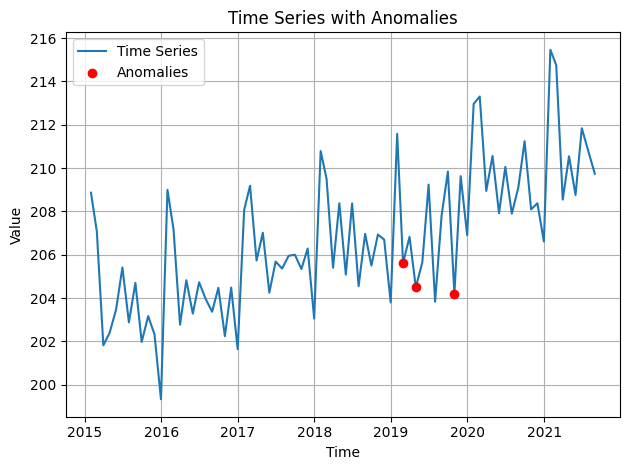

In [7]:
large_STL_resid = (abs(stl_result.resid) > 2)

plot_resid(stl_result.resid, hlines=[-2, 2])
plot_ts_with_anom(ts, large_STL_resid)

The residuals look independent and evenly spread across zero. Higher absolute values seem to occur from mid 2018 to late 2019.

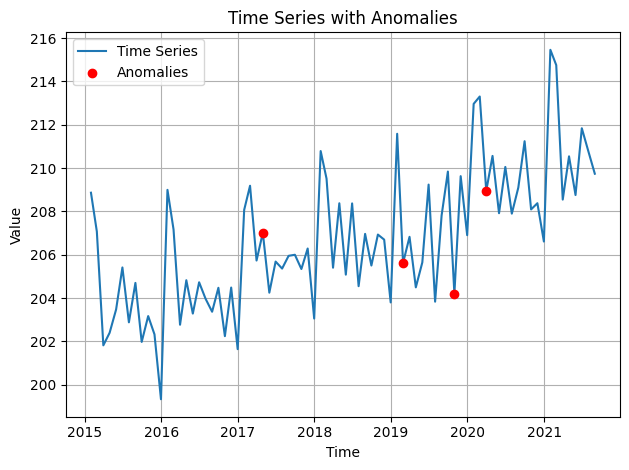

In [8]:
cusum_resid = cusum(stl_result.resid, stl_result.resid.mean(), threshold=(3 * stl_result.resid.std()), drift=(0.1 * stl_result.resid.std()))
plot_ts_with_anom(ts, cusum_resid)

No significant clusters are found by running CUSUM on the residuals, showing little change in mean of the residuals.

## 2.2 SARIMA Model
### Differenced Time Series

Base on part 2.1, it is safe to assume that there is a seasonal component of period 12 and a linear trend.

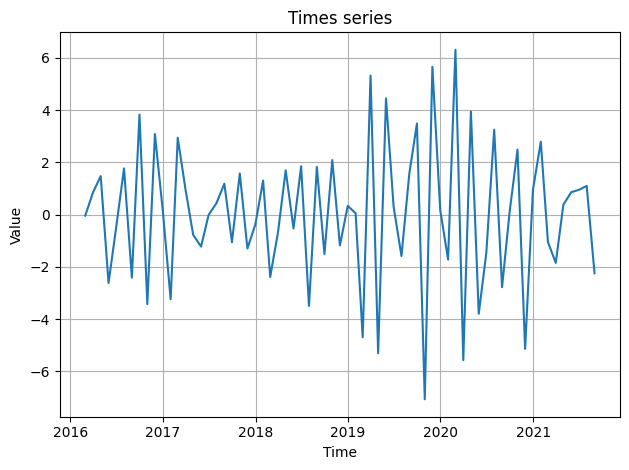

In [9]:
ts_diff = ts.diff(12).diff()
plot_ts(ts_diff)

This looks to have constant mean around zero, but with variablilty in variance.

In [10]:
from statsmodels.tsa.stattools import adfuller

stationary_pval = adfuller(ts_diff.dropna())[1]
print(f'p-value: {stationary_pval}')

p-value: 4.8360282180257404e-23


Applying the augmented Dickey–Fuller test on the differenced time series returns a very small $p$-value, thus there is strong evidence that the time series is stationary.

In [ ]:
# Sliding window variance

### SARIMA Model selection

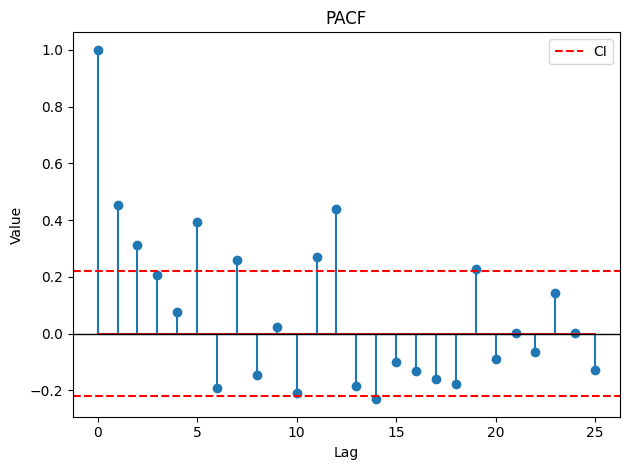

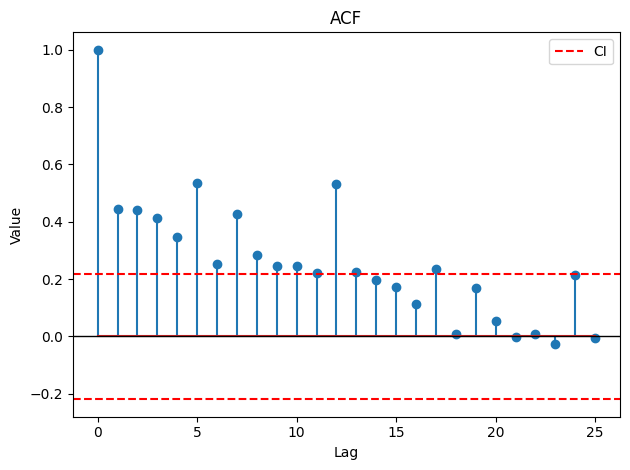

In [11]:
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import norm

nlags = 25
pacf_vals = pacf(ts, nlags=nlags)
acf_vals = acf(ts, nlags=nlags, fft=True)

conf_interval = norm.ppf(1 - 0.05 / 2) / np.sqrt(len(ts))
plot_lag_with_ci(pacf_vals, conf_interval, title='PACF')
plot_lag_with_ci(acf_vals, conf_interval, title='ACF')

Both the ACF and PACF plots have a notably high lag at $12$, suggesting $(P, D, Q)=(1, 1, 1)$. The ACF and PACF both seem to be deminished in value over higher lags, but have many statistically significant lags in the first period $(< 12)$. This might be due to small data sample size (total length of $80$ and post-differencing lenght of $67$). For simplicity, only $p, q < 3$ are considered.

In [13]:
from src.models.statistical.stationary_models import SARIMA_pq_grid_search

results_table = SARIMA_pq_grid_search(ts, period=12, d=1, D=1, max_p=3, max_q=3, max_P=1, max_Q=1)
df_results = pd.DataFrame(results_table).sort_values('AIC', na_position='last')

display(df_results[['order', 'seasonal_order', 'AIC', 'BIC']].head(10))

,order,seasonal_order,AIC,BIC
41,"(2, 1, 2)","(0, 1, 1, 12)",259.253959,272.482114
9,"(0, 1, 2)","(0, 1, 1, 12)",260.036413,268.855184
21,"(1, 1, 1)","(0, 1, 1, 12)",260.078248,268.897018
5,"(0, 1, 1)","(0, 1, 1, 12)",260.425171,267.039249
29,"(1, 1, 3)","(0, 1, 1, 12)",260.637306,273.865461
45,"(2, 1, 3)","(0, 1, 1, 12)",260.783010,276.215858
43,"(2, 1, 2)","(1, 1, 1, 12)",260.907071,276.339920
57,"(3, 1, 2)","(0, 1, 1, 12)",261.001090,276.433938
53,"(3, 1, 1)","(0, 1, 1, 12)",261.168926,274.397081
37,"(2, 1, 1)","(0, 1, 1, 12)",261.692461,272.715924


Note that there is no significant difference in `aic` for the top $10$ models. Taking `bic` and model simplicity into consideration, $SARIMA(0, 1, 1)(0, 1, 1, 12)$ is choosen to be the best model

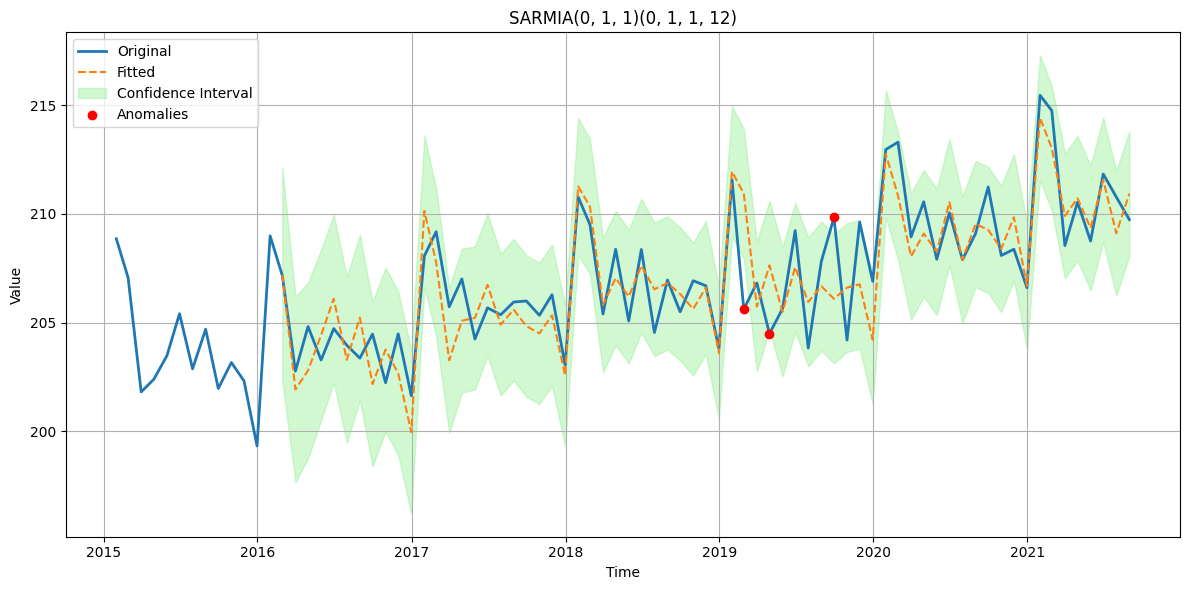

In [18]:
best_model = df_results.iloc[3]
plot_fit(ts, fitted_vals=best_model['model'].fittedvalues[13:], CI=best_model['conf_int'], anom=best_model['anom'], title=f'SARMIA{best_model['order']}{best_model['seasonal_order']}')

### SARIMA residual analysis

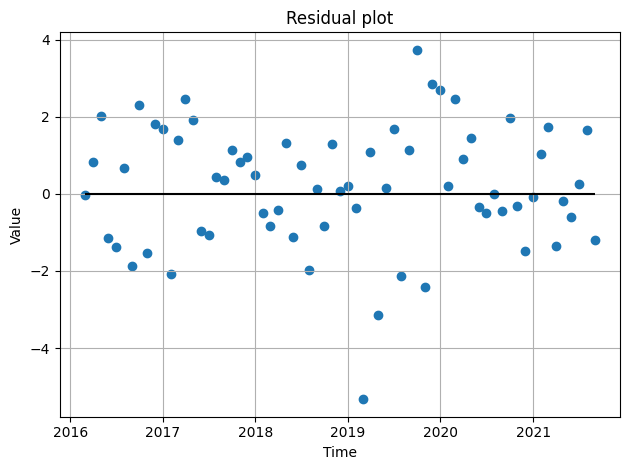

In [21]:
SARIMA_resid = best_model['model'].resid[13:]
plot_resid(SARIMA_resid)

In [ ]:
# Do rolling window variance + outlier cutoff

### Across model Anomalies

Going back to all the SARIMA models fitted during the grid search, we can look at the data points where all models had a hard time predicting

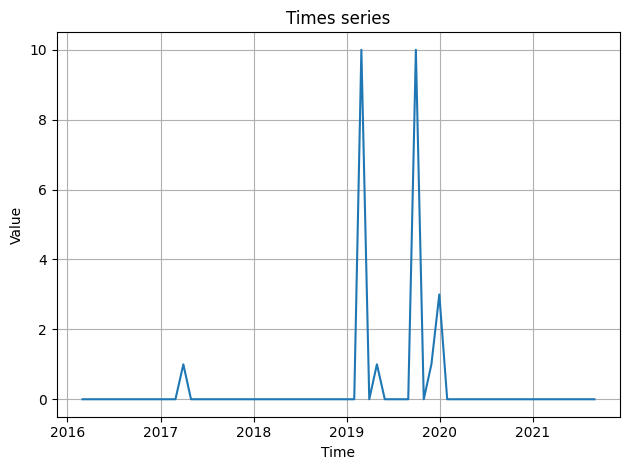

In [14]:
from src.models.statistical.stationary_models import count_anoms

anom_counts = count_anoms(df_results[['anom']].head(10))
plot_ts(anom_counts)

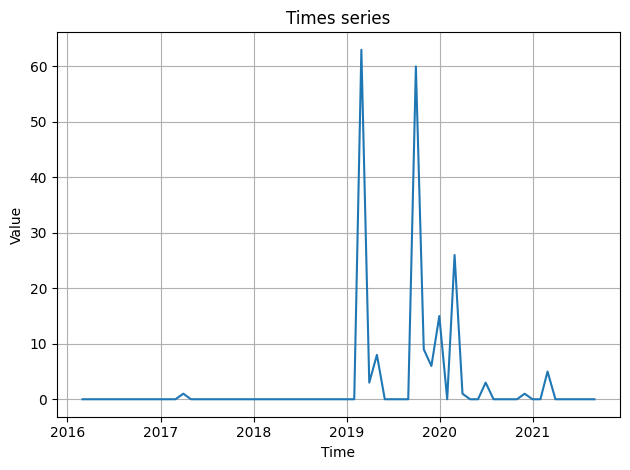

In [22]:
anom_counts = count_anoms(df_results[['anom']])
plot_ts(anom_counts)

This shows that models have a significatly harder time predicting data points from early 2019 to early 2020

## 2.3 BOCPD

from bayesian_changepoint_detection.priors import const_prior
from bayesian_changepoint_detection.bayesian_models import offline_changepoint_detection
import bayesian_changepoint_detection.offline_likelihoods as offline_ll
from functools import partial

prior_function = partial(const_prior, p=1/(len(resid) + 1))

Q, P, Pcp = offline_changepoint_detection(resid, prior_function ,offline_ll.StudentT(),truncate=-10)
values = np.insert(np.exp(Pcp).sum(0), 0, 0)
values = pd.Series(values.flatten(), index=resid.index)
# Pcp = 

fig, ax = plt.subplots(2, figsize=[18, 16], sharex=True)
ax[0].plot(resid[:])
ax[1].plot(values)

## 2.4 Kalman Filters

from pykalman import KalmanFilter
from scipy.stats import chi2

kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
kf = kf.em(ts.values, n_iter=10) 

filtered_state_means, filtered_state_covariances = kf.filter(ts.values)

print(filtered_state_means)
print(filtered_state_covariances)

predicted_means, predicted_covs = kf.filter_update(
    filtered_state_means[:-1], filtered_state_covariances[:-1], observation=ts.values[1:]
)

predicted_means = np.insert(predicted_means, 0, filtered_state_means[0])
predicted_covs = np.insert(predicted_covs, 0, filtered_state_covariances[0], axis=0)
std_devs = np.sqrt(np.squeeze(predicted_covs))

residuals = ts.values - predicted_means
nis = (residuals ** 2) / (std_devs ** 2)

# Chi-square cutoff for anomaly detection
cutoff = chi2.ppf(1, df=1)
is_anomaly = nis > cutoff

# Return anomalies as Series aligned to original index
anomalies = pd.Series(is_anomaly, index=ts.index)
filtered_series = pd.Series(filtered_state_means.flatten(), index=ts.index)

plt.plot(ts, label='Observations', alpha=0.5)
plt.plot(filtered_series, label='Kalman Filter Estimate')
plt.legend()
plt.show()
